In [1]:
# Import Libraries
import os
import pickle
import json
import warnings
import tweepy
import pandas as pd
import numpy as np
import sqlite3
import ast
import re
import string
import preprocessor as p
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, plot_confusion_matrix

from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
nltk.download('stopwords')
factory = StemmerFactory()
stemmer = factory.create_stemmer()
listStopword =  set(stopwords.words('indonesian'))  
engine = sqlite3.connect(os.path.join("..","db","data.db"), check_same_thread=False)
update = True

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jpawitro/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
consumerKey = " "
consumerSecret = " "
accessToken = " "
accessTokenSecret = " "


auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

engine = sqlite3.connect(os.path.join('..','db','data.db'), check_same_thread=False)

In [3]:
def crawling(keyword, noOfTweet):
    tweets = tweepy.Cursor(api.search, q=keyword, lang='id', tweet_mode='extended').items(noOfTweet)
    tweet_list = []

    for tweet in tweets:
        if 'retweeted_status' in tweet._json:
            tweet_text = [keyword,tweet._json['retweeted_status']['created_at'],tweet._json['retweeted_status']['user']['screen_name'],tweet._json['retweeted_status']['full_text']]
        else:
            tweet_text = [keyword,tweet.created_at,tweet.user.screen_name,tweet.full_text]
        tweet_list.append(tweet_text)
    tweet_list = pd.DataFrame(tweet_list, columns=['keywords','created_at','username','full_text'])
    tweet_list['created_at'] = pd.to_datetime(tweet_list['created_at'])
    tweet_list.drop_duplicates(inplace = True)
    return tweet_list

In [4]:
pd.DataFrame({
    "keywords":["#PJJ","#SekolahOnline","#sekolahdaring","#belajardarirumah","#daringclassroom","sekolah daring", "pembelajaran jarak jauh", "sekolah online",
    "#SekolahDiRumah"]
}).to_sql("keywords",con=engine, index=False, if_exists="replace")

In [5]:
pd.read_sql_query("select * from keywords", con=engine)

,keywords
0,#PJJ
1,#SekolahOnline
2,#sekolahdaring
3,#belajardarirumah
4,#daringclassroom
5,sekolah daring
6,pembelajaran jarak jauh
7,sekolah online
8,#SekolahDiRumah


In [6]:
keys = pd.read_sql_query("select * from keywords", con=engine).values.reshape(1,-1)[0].tolist()

In [7]:
if update:
    df = pd.DataFrame()
    for key in keys:
        n_list = crawling(key,1000)
        df = pd.concat([df,n_list])
    df.drop_duplicates(inplace = True)
    df['created_at'] = df['created_at'].astype(str).str.split('+',expand=True).loc[:,0]
    df.reset_index(drop=True,inplace=True)
    df.to_sql("crawling",con=engine,if_exists="replace",index=False)
else:
    df = pd.read_sql_query("select * from crawling", con=engine)
df

,keywords,created_at,username,full_text
0,#PJJ,2021-10-17 08:00:26,kelaspintar_id,Eits jangan nyerah dulu! Yuk lakukan hal-hal i...
1,#PJJ,2021-10-17 07:59:34,kelaspintar_id,"Sahabat Kelas Pintar, kamu pasti pernah mengal..."
2,#PJJ,2021-10-16 06:51:49,ditpsd_dikbud,"#SahabatSekolahDasar, ayo, coba tebak kata-kat..."
3,#PJJ,2021-10-15 04:51:08,kelaspintar_id,Pakai aja Quiz pada SOAL dari Kelas Pintar! Ng...
4,#PJJ,2021-10-15 04:50:49,kelaspintar_id,"Sudah belajar, nggak lengkap kalo nggak pakai ..."
...,...,...,...,...
1775,sekolah online,2021-10-16 01:58:37,chizznanda,Dah bener sekolah online aja https://t.co/zQ7o...
1776,sekolah online,2021-10-16 01:52:44,namanyafarsya,IH BENER2 DAH BOCAH JAMAN SEKARANG ADA BANGETT...
1777,sekolah online,2021-10-16 01:48:03,danizaayua,"@bertanyarl Aku pake yang bawah, belom pernah ..."
1778,#SekolahDiRumah,2021-10-18 09:02:43,KKB_Malang,Yuk menjaga 'kewarasan' kita dan menata diri s...


In [8]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

emoticons = emoticons_happy.union(emoticons_sad)

In [9]:
df_cleaned = df.iloc[:,:2].copy()
cleaned = []
for n in df['full_text'].values:
    n = p.clean(n)
    n = n.lower()
    n = re.sub(r':', '', n)
    n = re.sub(r'‚Ä¶', '', n)
    n = re.sub(r'[^\x00-\x7F]+',' ', n)
    n = emoji_pattern.sub(r'', n)
    n = re.sub('[^a-zA-Z]', ' ', n)
    n = re.sub("&lt;/?.*?&gt;","&lt;&gt;",n)
    n = re.sub("(\\d|\\W)+"," ",n)
    n = re.sub(r'â', '', n)
    n = re.sub(r'€', '', n)
    n = re.sub(r'¦', '', n)
    cleaned.append(n)
df['cleaned'] = cleaned

In [10]:
file_2  = open(os.path.join("..","data","cleaning_source","update_combined_slang_words.txt"), "r")
content2 = file_2.read()
slang_words = ast.literal_eval(content2)

In [11]:
tokenized = []
df_tokenized = df.iloc[:,:2].copy()
for n in cleaned:
    n = word_tokenize(n)
    for w in n:
        if w in slang_words.keys():
            n[n.index(w)] = slang_words[w]
    tokenized.append(n)
df['tokenized'] = [', '.join(n) for n in tokenized]

In [12]:
removed = []
listtoberemoved = ["#PJJ","#SekolahOnline","#sekolahdaring","#belajardarirumah","#daringclassroom","sekolah daring", "pembelajaran jarak jauh", "sekolah online", "#SekolahDiRumah"]
for ts in tokenized:
    n = []
    for t in ts:
        if t not in keys+listtoberemoved and t not in listStopword and t not in emoticons and t not in string.punctuation:
            n.append(t)
    removed.append(n)
df['removed'] = [', '.join(n) for n in removed]

In [13]:
stemmed = []
for n in removed:
    n = ' '.join(n)
    n = stemmer.stem(n)
    n = n.split(' ')
    stemmed.append(n)
df['stemmed'] = [' '.join(n) for n in stemmed]

In [14]:
df.to_csv(os.path.join('..','data','prep.csv'),index=False)
df.to_excel(os.path.join('..','data','prep.xlsx'),index=False)

In [15]:
df = pd.read_csv(os.path.join('..','data','prep.csv'))

In [16]:
stemmed = [word_tokenize(n) for n in df['stemmed'].values]

In [17]:
negasi = ['bukan','tidak','ga','gk']
lexicon = pd.read_csv(os.path.join('..','data','lexicon','modified_full_lexicon.csv'))
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')
                               |(lexicon['word'] == 'tidak')
                               |(lexicon['word'] == 'ga')|(lexicon['word'] == 'gk') ].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [18]:
sencol =[]
senrow =np.array([])
nsen = 0
lexicon_word = lexicon['word'].to_list()
sentiment_list = []
def found_word(ind,words,word,sen,sencol,sentiment,add):
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
        sencol.append(word)
        sen.append(1)
        add += 1
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
for i in range(len(stemmed)):
    nsen = senrow.shape[0]
    sentiment = 0 
    words = stemmed[i].copy()
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [19]:
sencol.append('sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)
df_sen.head(10)

,nyerah,yuk,gagal,sahabat,kelas,alami,campur,aduk,ken,ayo,...,ana,prihatin,modal,amin,dibully,bangett,konyol,singkat,waras,sentiment
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-3
1,1,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,-4
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,16
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,23
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
7,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7


In [20]:
cek_df = pd.DataFrame([])
cek_df['text'] = df['full_text'].copy()
cek_df['sentiment']  = df_sen['sentiment'].copy()
cek_df.head(10)

,text,sentiment
0,Eits jangan nyerah dulu! Yuk lakukan hal-hal i...,-3
1,"Sahabat Kelas Pintar, kamu pasti pernah mengal...",-4
2,"#SahabatSekolahDasar, ayo, coba tebak kata-kat...",16
3,Pakai aja Quiz pada SOAL dari Kelas Pintar! Ng...,3
4,"Sudah belajar, nggak lengkap kalo nggak pakai ...",23
5,Semoga Isteri tabah dan kuat seorang diri di r...,11
6,Mau belajar lebih lanjut tentang peredaran dar...,11
7,"Biar nggak penasaran, simak langsung nih penje...",6
8,"Pernah nggak sih kamu bertanya-tanya, kenapa g...",7
9,Nadiem Cairkan Jatah Kuota Internet PJJ ke 26 ...,7


Text(0.5, 0, 'sentiment')

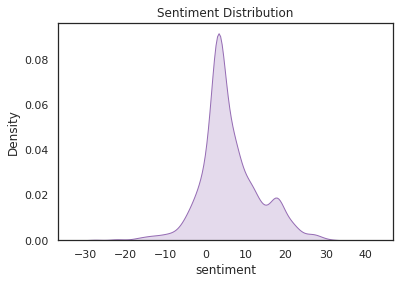

In [21]:
sns.set(style="white", palette="muted", color_codes=True)
sns.kdeplot(df_sen['sentiment'],color='m',shade=True)
plt.title('Sentiment Distribution')
plt.xlabel('sentiment')

<AxesSubplot:xlabel='sentiment'>

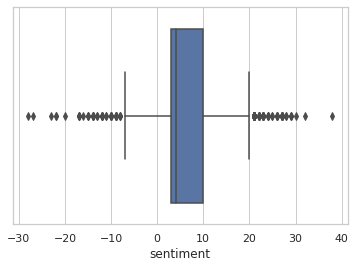

In [22]:
sns.set(style="whitegrid") 
sns.boxplot(x=df_sen['sentiment'])

In [23]:
df_sen.describe()

,nyerah,yuk,gagal,sahabat,kelas,alami,campur,aduk,ken,ayo,...,ana,prihatin,modal,amin,dibully,bangett,konyol,singkat,waras,sentiment
count,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,...,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000
mean,0.002247,0.010112,0.002809,0.003371,0.061798,0.003371,0.001124,0.001124,0.035393,0.005618,...,0.000562,0.000562,0.000562,0.000562,0.000562,0.000562,0.000562,0.000562,0.000562,5.932022
std,0.047365,0.115708,0.052940,0.057977,0.302883,0.057977,0.033511,0.033511,0.207734,0.081938,...,0.023702,0.023702,0.023702,0.023702,0.023702,0.023702,0.023702,0.023702,0.023702,7.387332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
max,1.000000,3.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,3.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,38.000000


In [24]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

au = get_top_abs_correlations(df_sen, 15)

In [25]:
top10 = au[au<float(1)][0:10]
label = top10.index
label_list =[]
for i in label:
    for j in i:
        if(j not in label_list):
            label_list.append(j)
            
df_sen_corr = df_sen[label_list]
corr = df_sen_corr.corr()
for i in label_list:
    for j in label_list:
        if i!=j:
            corr[i][j] = round(corr[i][j],3)

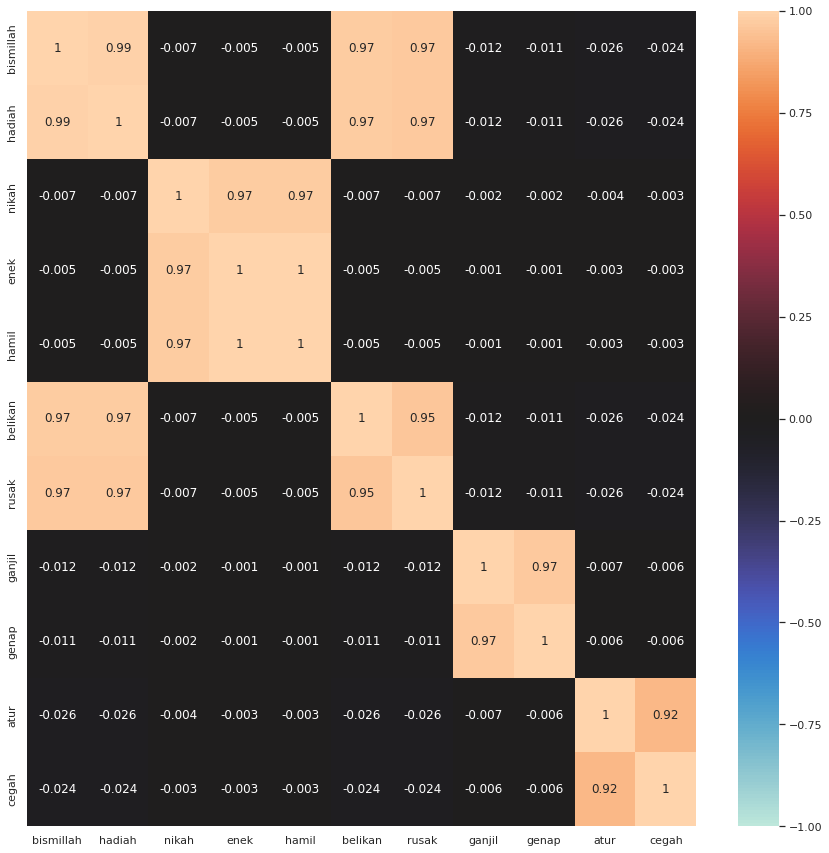

In [26]:
plt.figure(figsize=(15,15))

h = sns.heatmap(corr, annot=True,vmin=-1, vmax=1, center= 0)

plt.show()

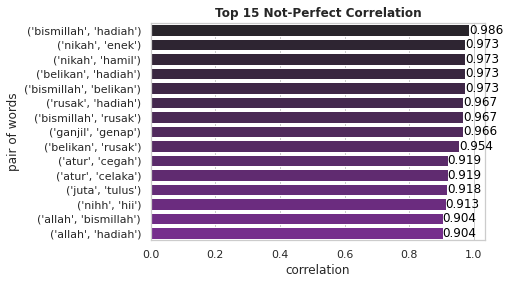

In [27]:
top15 = au[au<float(1)][0:15]
pal =sns.dark_palette("purple", input="xkcd",n_colors=15)
g = sns.barplot(y = [str(n) for n in top15.index] , x = top15,palette=pal)
g.grid=False
plt.xlabel('correlation')
plt.ylabel('pair of words')
plt.title("Top 15 Not-Perfect Correlation",fontweight='bold') 
for i in range(15):
    g.text(top15[i],i+0.22, round(top15[i],3),color='black')
plt.show()

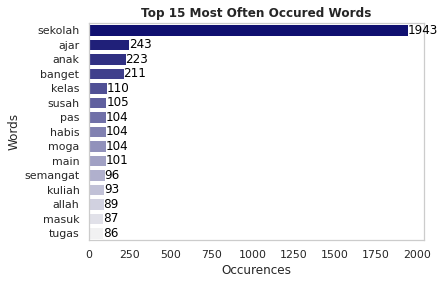

In [28]:
top15_word = df_sen.drop(['sentiment'],axis=1).sum().sort_values(ascending=False)[0:15]
pal =sns.light_palette("navy", reverse=True,n_colors=15)
g = sns.barplot(y = top15_word.index , x = top15_word,palette=pal)
g.grid(False)
plt.xlabel('Occurences')
plt.ylabel('Words')
plt.title("Top 15 Most Often Occured Words",fontweight='bold') 
for i in range(15):
    g.text(top15_word[i],i+0.22, top15_word[i],color='black')
plt.show()

In [29]:
df['sentiment'] = df_sen['sentiment']

In [30]:
df.head(5)

,keywords,created_at,username,full_text,cleaned,tokenized,removed,stemmed,sentiment
0,#PJJ,2021-10-17 08:00:26,kelaspintar_id,Eits jangan nyerah dulu! Yuk lakukan hal-hal i...,eits jangan nyerah dulu yuk lakukan hal hal in...,"eits, jangan, nyerah, dulu, yuk, lakukan, hal,...","eits, nyerah, yuk, lakukan, menghadapi, kegagalan",eits nyerah yuk laku hadap gagal,-3
1,#PJJ,2021-10-17 07:59:34,kelaspintar_id,"Sahabat Kelas Pintar, kamu pasti pernah mengal...",sahabat kelas pintar kamu pasti pernah mengala...,"sahabat, kelas, pintar, kamu, pasti, pernah, m...","sahabat, kelas, pintar, mengalami, namanya, ke...",sahabat kelas pintar alami nama gagal campur a...,-4
2,#PJJ,2021-10-16 06:51:49,ditpsd_dikbud,"#SahabatSekolahDasar, ayo, coba tebak kata-kat...",ayo coba tebak kata kata yang ada di gambar s...,"ayo, coba, tebak, kata, kata, yang, ada, di, g...","ayo, coba, tebak, gambar, hubungannya, iya, lu...",ayo coba tebak gambar hubung iya lupa jawab ko...,16
3,#PJJ,2021-10-15 04:51:08,kelaspintar_id,Pakai aja Quiz pada SOAL dari Kelas Pintar! Ng...,pakai aja quiz pada soal dari kelas pintar ngg...,"pakai, saja, quiz, pada, soal, dari, kelas, pi...","pakai, quiz, kelas, pintar, bikin, latihan, ng...",pakai quiz kelas pintar bikin latih ngerjain s...,3
4,#PJJ,2021-10-15 04:50:49,kelaspintar_id,"Sudah belajar, nggak lengkap kalo nggak pakai ...",sudah belajar nggak lengkap kalo nggak pakai l...,"sudah, belajar, tidak, lengkap, kalau, tidak, ...","belajar, lengkap, pakai, latihan, uji, pemaham...",ajar lengkap pakai latih uji paham ken pakai k...,23


In [31]:
df.loc[df['sentiment'] == 0, 'label'] = 'neutral'
df.loc[df['sentiment'] > 0, 'label'] = 'positive'
df.loc[df['sentiment'] < 0, 'label'] = 'negative'
df['label'].value_counts()

positive    1486
negative     222
neutral       72
Name: label, dtype: int64

In [32]:
vectorizer = CountVectorizer(max_features=1500, min_df=2, max_df=0.8)
X = vectorizer.fit_transform([" ".join(x) for x in stemmed]).toarray()
pd.DataFrame(X,columns=vectorizer.get_feature_names()).to_csv("../data/tfidf.csv",index=None)

In [33]:
pd.DataFrame(X,columns=vectorizer.get_feature_names())

,aaaa,aaaaa,aamiin,ab,absen,absensi,acara,ada,adab,adaptasi,...,yayasan,yh,you,youtube,yt,yuk,yya,zaman,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [34]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
pd.DataFrame(X,columns=vectorizer.get_feature_names()).to_csv(os.path.join("..","data","tfidf_norm.csv"),index=None)

In [35]:
le = LabelEncoder()
y = le.fit_transform(df['label'])
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [36]:
sm = SMOTE()
Xres,yres = sm.fit_resample(X,y)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(Xres, yres, test_size = 0.2, random_state=42, shuffle=True)

In [38]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=1000)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=10,
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


{'var_smoothing': 1.2305240043592616e-05}

In [39]:
y_pred = gs_NB.predict(X_train)
y_pred_ = gs_NB.predict(X_test)

In [40]:
print(classification_report(y_train,y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.91      0.97      0.94      1196
     neutral       0.86      1.00      0.92      1196
    positive       1.00      0.76      0.87      1174

    accuracy                           0.91      3566
   macro avg       0.92      0.91      0.91      3566
weighted avg       0.92      0.91      0.91      3566



In [41]:
print(classification_report(y_test,y_pred_, target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.85      0.98      0.91       290
     neutral       0.84      1.00      0.91       290
    positive       1.00      0.69      0.82       312

    accuracy                           0.88       892
   macro avg       0.90      0.89      0.88       892
weighted avg       0.90      0.88      0.88       892



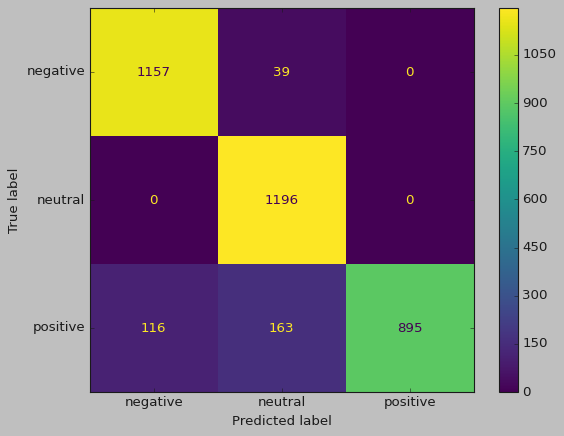

In [42]:
plt.style.use('classic')
plot_confusion_matrix(gs_NB,X_train,y_train, values_format = '.5g', display_labels=le.classes_)
plt.show()

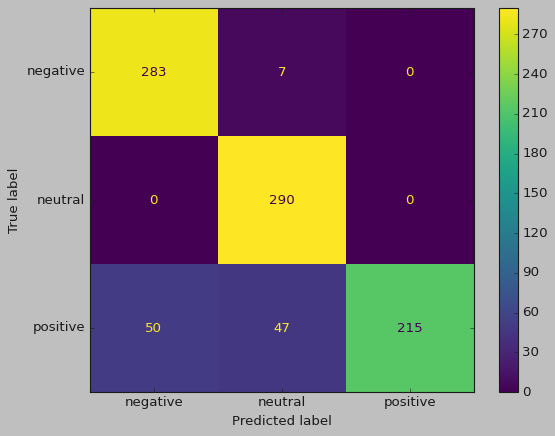

In [43]:
plt.style.use('classic')
plot_confusion_matrix(gs_NB,X_test,y_test, values_format = '.5g', display_labels=le.classes_)
plt.show()

In [44]:
pickle.dump(vectorizer,open(os.path.join('..','model','vectorizer.sav'),'wb'))
pickle.dump(tfidfconverter,open(os.path.join('..','model','tfidfconverter.sav'),'wb'))
pickle.dump(le,open(os.path.join('..','model','le.sav'),'wb'))
pickle.dump(sm,open(os.path.join('..','model','smote.sav'),'wb'))
pickle.dump(gs_NB,open(os.path.join('..','model','clf.sav'),'wb'))

In [45]:
df

,keywords,created_at,username,full_text,cleaned,tokenized,removed,stemmed,sentiment,label
0,#PJJ,2021-10-17 08:00:26,kelaspintar_id,Eits jangan nyerah dulu! Yuk lakukan hal-hal i...,eits jangan nyerah dulu yuk lakukan hal hal in...,"eits, jangan, nyerah, dulu, yuk, lakukan, hal,...","eits, nyerah, yuk, lakukan, menghadapi, kegagalan",eits nyerah yuk laku hadap gagal,-3,negative
1,#PJJ,2021-10-17 07:59:34,kelaspintar_id,"Sahabat Kelas Pintar, kamu pasti pernah mengal...",sahabat kelas pintar kamu pasti pernah mengala...,"sahabat, kelas, pintar, kamu, pasti, pernah, m...","sahabat, kelas, pintar, mengalami, namanya, ke...",sahabat kelas pintar alami nama gagal campur a...,-4,negative
2,#PJJ,2021-10-16 06:51:49,ditpsd_dikbud,"#SahabatSekolahDasar, ayo, coba tebak kata-kat...",ayo coba tebak kata kata yang ada di gambar s...,"ayo, coba, tebak, kata, kata, yang, ada, di, g...","ayo, coba, tebak, gambar, hubungannya, iya, lu...",ayo coba tebak gambar hubung iya lupa jawab ko...,16,positive
3,#PJJ,2021-10-15 04:51:08,kelaspintar_id,Pakai aja Quiz pada SOAL dari Kelas Pintar! Ng...,pakai aja quiz pada soal dari kelas pintar ngg...,"pakai, saja, quiz, pada, soal, dari, kelas, pi...","pakai, quiz, kelas, pintar, bikin, latihan, ng...",pakai quiz kelas pintar bikin latih ngerjain s...,3,positive
4,#PJJ,2021-10-15 04:50:49,kelaspintar_id,"Sudah belajar, nggak lengkap kalo nggak pakai ...",sudah belajar nggak lengkap kalo nggak pakai l...,"sudah, belajar, tidak, lengkap, kalau, tidak, ...","belajar, lengkap, pakai, latihan, uji, pemaham...",ajar lengkap pakai latih uji paham ken pakai k...,23,positive
...,...,...,...,...,...,...,...,...,...,...
1775,sekolah online,2021-10-16 01:58:37,chizznanda,Dah bener sekolah online aja https://t.co/zQ7o...,dah bener sekolah online aja,"deh, benar, sekolah, online, saja","deh, sekolah, online",deh sekolah online,3,positive
1776,sekolah online,2021-10-16 01:52:44,namanyafarsya,IH BENER2 DAH BOCAH JAMAN SEKARANG ADA BANGETT...,ih bener dah bocah jaman sekarang ada bangett ...,"ih, benar, deh, bocah, jaman, sekarang, ada, b...","ih, deh, bocah, jaman, bangett, kerjaan, konyo...",ih deh bocah jaman bangett kerja konyol deh ad...,-4,negative
1777,sekolah online,2021-10-16 01:48:03,danizaayua,"@bertanyarl Aku pake yang bawah, belom pernah ...",aku pake yang bawah belom pernah pake yang ata...,"aku, pakai, yang, bawah, belum, pernah, pakai,...","pakai, pakai, review, singkat, on, ear, enak, ...",pakai pakai review singkat on ear enak pas kup...,12,positive
1778,#SekolahDiRumah,2021-10-18 09:02:43,KKB_Malang,Yuk menjaga 'kewarasan' kita dan menata diri s...,yuk menjaga kewarasan kita dan menata diri saa...,"yuk, menjaga, kewarasan, kita, dan, menata, di...","yuk, menjaga, kewarasan, menata, menemani, ana...",yuk jaga waras tata tani anak terap komponen s...,8,positive


In [46]:
df.to_excel(os.path.join("..","data","data_sentiment.xlsx"),index=False)
df.to_sql("data",con=engine,if_exists="replace",index=False)

In [47]:
df_sen.to_excel(os.path.join("..","data","scoring_sentiment.xlsx"),index=False)
df_sen.to_sql("sentiment",con=engine,if_exists="replace",index=False)

In [48]:
json.dump(gs_NB.best_params_,open(os.path.join('..','data','best_params.json'),'w'))